# Encoding model tutorial

In [1]:
import mne
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
use_gpu = True

if torch.cuda.is_available():
    set_backend("torch_cuda")

## get features

In [3]:
# modelname, layer = 'gemma2-2b', 13
modelname, layer = 'gpt2-xl', 24

with h5py.File(f"../monkey/stimuli/{modelname}/states.hdf5", "r") as f:
    embeddings = f[f"layer-{layer}"][...]
embeddings.shape

(5774, 1600)

In [4]:
df = pd.read_csv(f"../monkey/stimuli/{modelname}/transcript.tsv", sep="\t", index_col=0)

if 'rank' in df.columns:
    model_acc = (df['rank'] == 0).mean()
    print(f"Model accuracy: {model_acc*100:.3f}%")

print(df.shape)
df.head()

Model accuracy: 37.617%
(5774, 11)


,word_idx,word,start,end,score,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,0.367,ĠAct,2191,1644,0.000012,0,2.402717
1,1,"one,",3.990,4.190,0.688,Ġone,530,92,0.000342,352,3.732054
2,1,"one,",3.990,4.190,0.688,",",11,3,0.059520,25,4.259334
3,2,monkey,4.651,4.931,0.866,Ġmonkey,21657,4022,0.000018,3715,6.621269
4,3,in,4.951,5.011,0.780,Ġin,287,15,0.004237,0,4.444837


In [5]:
aligned_embeddings = []
for _, group in df.groupby("word_idx"):
    indices = group.index.to_numpy()
    average_emb = embeddings[indices].mean(0)
    aligned_embeddings.append(average_emb)
aligned_embeddings = np.stack(aligned_embeddings)
aligned_embeddings.shape

(4794, 1600)

In [6]:
df = df.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df.shape

(4794, 3)

In [7]:
good_mask = df['start'].notna().to_numpy()
aligned_embeddings = aligned_embeddings[good_mask]
aligned_embeddings.shape

(4774, 1600)

In [8]:
df.dropna(subset=['start'], inplace=True)
df.shape

(4774, 3)

# load brain data

In [9]:
edf_path = BIDSPath(
    root="../monkey/derivatives/ecogprep",
    subject="02",
    datatype="ieeg",
    description="highgamma",
    extension=".fif",
)
edf_path = edf_path.match()[0]

raw = mne.io.read_raw_fif(edf_path)
raw

Opening raw data file ../monkey/derivatives/ecogprep/sub-02/ieeg/sub-02_task-monkey_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.


Measurement date,"March 11, 2019 10:54:21 GMT"
Experimenter,Unknown
Participant,sub-02
Digitized points,189 points
Good channels,186 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,70.00 Hz
Lowpass,200.00 Hz


In [10]:
events = np.zeros((len(df), 3), dtype=int)
events[:, 0] = (df.start * raw.info['sfreq']).astype(int)
events.shape

(4774, 3)

In [11]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-2.0,
    tmax=2.0,
    baseline=None,
    proj=False,
    event_id=None,
    preload=True,
    event_repeated="merge",
)
epochs._data.shape

Not setting metadata
4774 matching events found
No baseline correction applied
Loading data for 4774 events and 2049 original time points ...
6 bad epochs dropped


(4768, 186, 2049)

In [12]:
epochs = epochs.resample(sfreq=32, npad='auto', method='fft', window='hamming')
# epochs = epochs.resample(sfreq=32, npad='auto', method='polyphase')
epochs._data.shape

(4768, 186, 128)

Need more than one channel to make topography for ecog. Disabling interactivity.


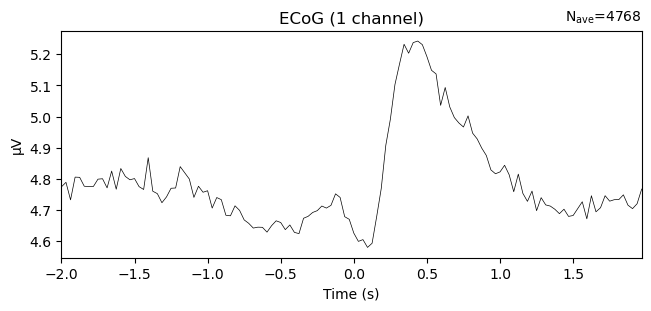

In [25]:
evoked = epochs.average()
evoked = evoked.pick("LGA10")
evoked.plot()
plt.show()

# encoding model analyses

## setup data

In [13]:
epochs_data = epochs.get_data(copy=True)
epochs_data = epochs_data.reshape(len(epochs), -1)

epochs_shape = epochs._data.shape[1:]

epochs_shape, epochs_data.shape

((186, 128), (4768, 23808))

In [14]:
selected_df = df.iloc[epochs.selection]
averaged_embeddings = aligned_embeddings[epochs.selection]
averaged_embeddings.shape

(4768, 1600)

In [15]:
X = averaged_embeddings
Y = epochs_data

if use_gpu:
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

X.shape, Y.shape

((4768, 1600), (4768, 23808))

## build model

In [16]:
alphas = np.logspace(1, 10, 10)
inner_cv = KFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(), RidgeCV(alphas, fit_intercept=True, cv=inner_cv)
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                         cv=KFold(n_splits=5, random_state=None, shuffle=False),
                         fit_intercept=True))])

## train model

In [27]:
corrs = []

kfold = KFold(2, shuffle=False)
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    break

    scaler = StandardScaler()
    Y_train = scaler.fit_transform(Y_train)
    Y_test = scaler.transform(Y_test)

    model.fit(X_train, Y_train)
    Y_preds = model.predict(X_test)
    corr = correlation_score(Y_test, Y_preds).reshape(epochs_shape)
    
    if use_gpu:
        corr = corr.numpy(force=True)

    corrs.append(corr)

corrs = np.stack(corrs)
corrs.shape

ValueError: need at least one array to stack

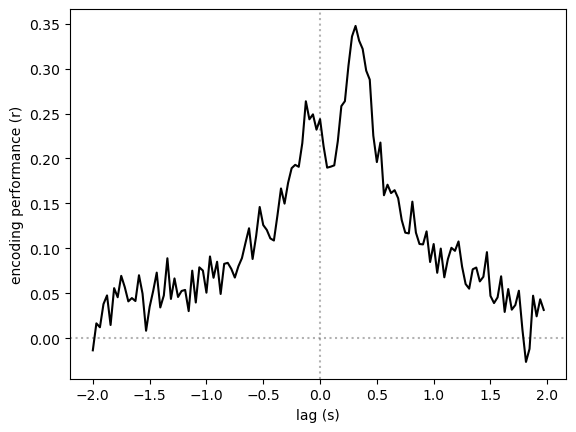

In [18]:
lags = np.arange(-2 * 512, 2 * 512, 16) / 512

electrode = 'LGA10'
electrode_id = raw.info['ch_names'].index(electrode)

plt.axvline(0, c='k', alpha=0.3, ls=':')
plt.axhline(0, c='k', alpha=0.3, ls=':')
plt.plot(lags, corrs.mean(0)[electrode_id], c='k')
plt.xlabel('lag (s)')
plt.ylabel('encoding performance (r)')
plt.show()

In [19]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
coords.shape

(186, 3)

(186,)


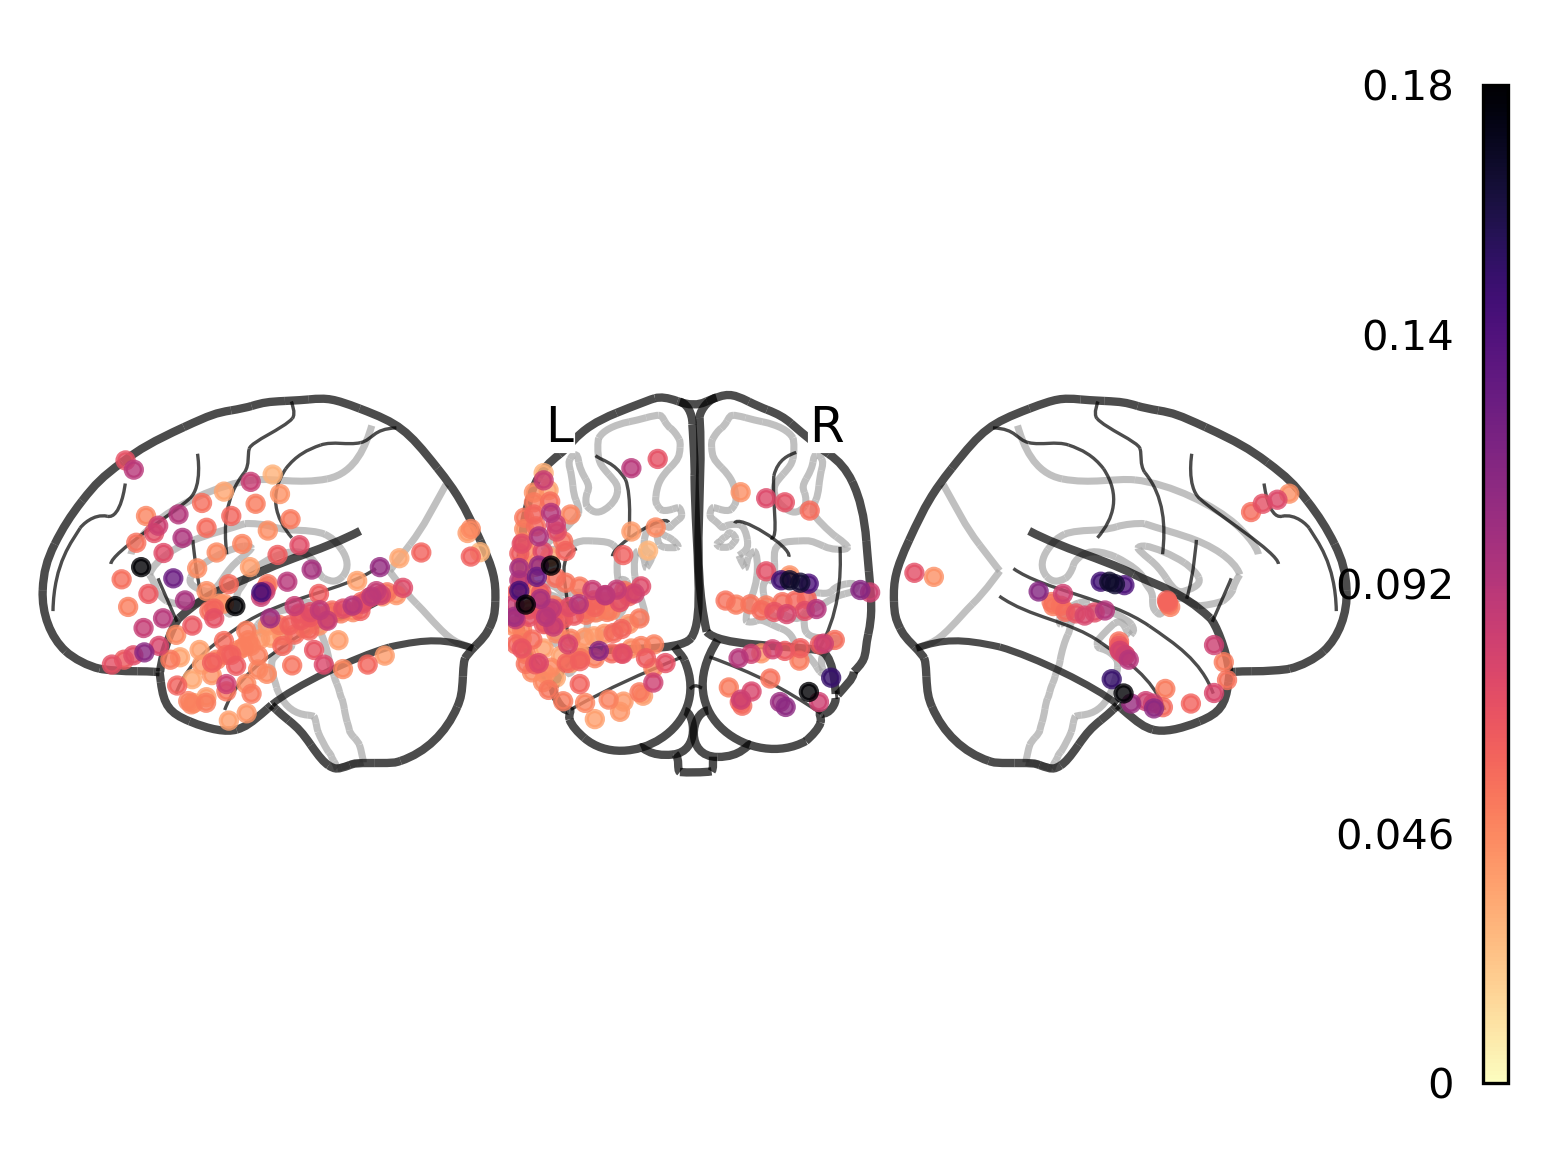

In [20]:
scores = corrs.mean(0).max(-1)
print(scores.shape)
vmax = np.quantile(scores, .99)

fig, ax = plt.subplots(dpi=300)
order = scores.argsort()
plot_markers(scores[order], coords[order],
             node_size=15, display_mode='lyr',
             node_vmin=0, node_vmax=vmax,
             figure=fig, axes=ax, alpha=0.8,
             node_cmap='magma_r', colorbar=True)
fig.show()